In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes


from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [4]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 15/15 [00:14<00:00,  1.07it/s]

CPU times: user 244 ms, sys: 296 ms, total: 539 ms
Wall time: 14.1 s


## Subset of reads with at least 3 SNPs 

In [10]:
%%time
NCO_df = (reads_df
    .select(
        'read_name',
        'read_length',
        'chrom',
        'sample_id',
        'grch37_chromosome_size_in_bp',
        'high_quality_snp_positions',
        "high_quality_snp_positions_alleles",
        'CO_active_interval_start',
        'CO_active_interval_end',
        "CO_active_interval_length_bp",
        "CO_active_interval_start_cM",
        "CO_active_interval_end_cM",
        'NCO_active_interval_start',
        'NCO_active_interval_end',
        'NCO_active_interval_length_bp',
        'grch37_reference_start',
        'grch38_reference_start',
        'grch37_reference_end',
        'grch38_reference_end',
        'grch37_reference_start_cM',
        'grch37_reference_end_cM',
        'NCO_active_interval_start_cM',
        'NCO_active_interval_end_cM',
        'CO_active_interval_crossover_prob',
        "full_read_crossover_prob",
        "mid_CO_active_interval_crossover_prob",
        'NCO_active_interval_crossover_prob',
        "NCO_prob_detection_in_CO_active_interval",
        'AA_motif_center_pos',
        'AA_heat',
        'AA_motif_strand',
        'is_high_quality_read',
        "min_coverage_hap1",
        "min_coverage_hap2",
        "high_quality_classification_class",
        "snp_positions_on_read", 
        "idx_transitions",
        "high_quality_classification_in_detectable_class",
        "between_mid_quality_snps_cM",
        "between_high_quality_snps_cM",
        "before_read_cM",
        "after_read_cM",        
    )
    .filter(pl.col("high_quality_classification_class") == "GC")
    .filter(pl.col("high_quality_snp_positions").list.len() >= 3)
    .filter("is_high_quality_read")
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
    .collect()
)

CPU times: user 5min 42s, sys: 1min 3s, total: 6min 46s
Wall time: 1min 6s


In [26]:
NCO_df = (NCO_df
    .filter(pl.col("high_quality_classification_class") == "GC")
    .with_columns(
        grch37_recombining_interval_start_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch37_recombining_interval_end_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch38_recombining_interval_start_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch38_recombining_interval_end_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch37_first_converted_marker_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
        grch38_first_converted_marker_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
    )
    .with_columns(
        grch37_recombining_interval_length = pl.col("grch37_recombining_interval_end_pos") - pl.col("grch37_recombining_interval_start_pos"),                
        grch38_recombining_interval_length = pl.col("grch38_recombining_interval_end_pos") - pl.col("grch38_recombining_interval_start_pos"),                
    )
)

dfs = []
for [chrom], df in NCO_df.partition_by(by=["chrom"], as_dict=True).items():
    rate_map = annotate.rate_maps[chrom]
    dfs.append(
        df.with_columns(
            grch37_recombining_interval_start_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_start_pos"]) * 1e2,
            grch37_recombining_interval_end_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_end_pos"]) * 1e2,
            grch37_first_converted_marker_poses_rate = rate_map.get_rate(df["grch37_first_converted_marker_pos"]) * 1e2,
        ).with_columns(
            grch37_recombining_interval_cM = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")),
            grch37_cM_per_bp_across_recombining_interval = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")) / pl.col("grch37_recombining_interval_length"),
        )
    )
    
NCO_df = pl.concat(dfs)
NCO_df = NCO_df.filter(pl.col("grch37_recombining_interval_cM") > 0)


# Tract length upper bound vs. cM?

In [27]:
NCO_df = (NCO_df
    .with_columns(
        upper_bound = \
        (
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1) -
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0))
        )
    )    
)

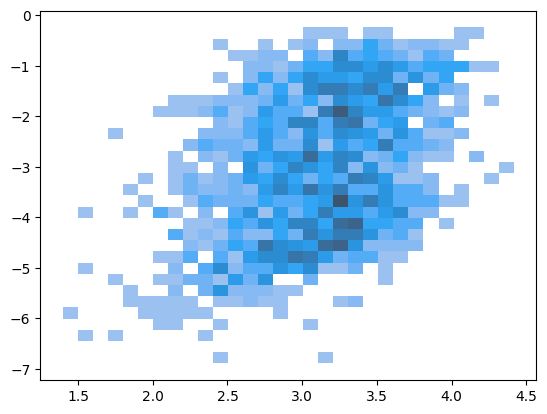

In [28]:
sns.histplot(
    x = NCO_df["upper_bound"].log10().to_numpy(),
    y = NCO_df["grch37_recombining_interval_cM"].log10().to_numpy(),
    bins=30,
);

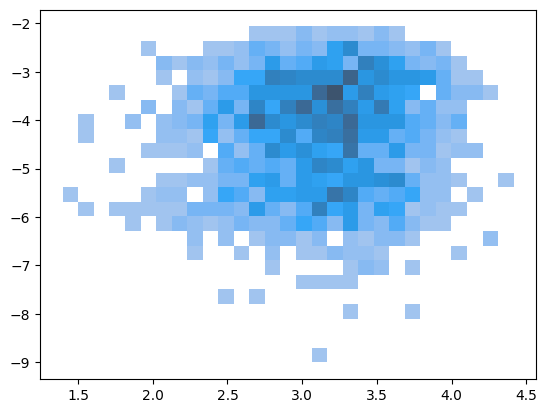

In [20]:
sns.histplot(
    x = NCO_df["upper_bound"].log10().to_numpy(),
    y = NCO_df["CO_active_interval_crossover_prob"].log10().to_numpy(),
);

In [43]:
scipy.stats.pearsonr(
    NCO_df["upper_bound"].to_numpy(),
    NCO_df["CO_active_interval_crossover_prob"].to_numpy(),
)

PearsonRResult(statistic=0.012582174266861609, pvalue=0.6105235121263637)

In [45]:
scipy.stats.pearsonr(
    NCO_df["upper_bound"].to_numpy(),
    NCO_df["grch37_cM_per_bp_across_recombining_interval"].to_numpy(),
)

PearsonRResult(statistic=-0.07542188618459063, pvalue=0.002233317981430797)

In [46]:
scipy.stats.pearsonr(
    NCO_df["upper_bound"].log10().to_numpy(),
    NCO_df["grch37_cM_per_bp_across_recombining_interval"].log10().to_numpy(),
)

PearsonRResult(statistic=0.0682653281362011, pvalue=0.005666189323002642)

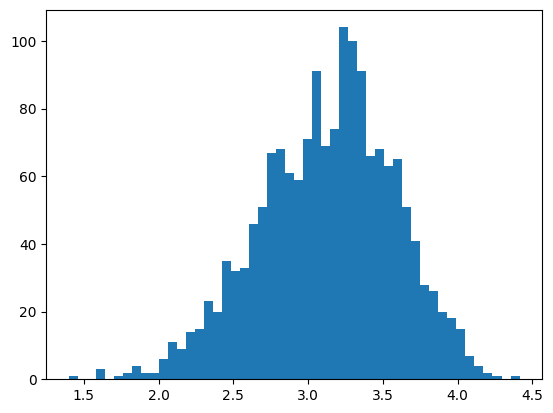

In [31]:
plt.hist(
    NCO_df.filter(pl.col("grch37_recombining_interval_cM") > 0)["upper_bound"].log10().to_numpy(),
    bins=50,
);

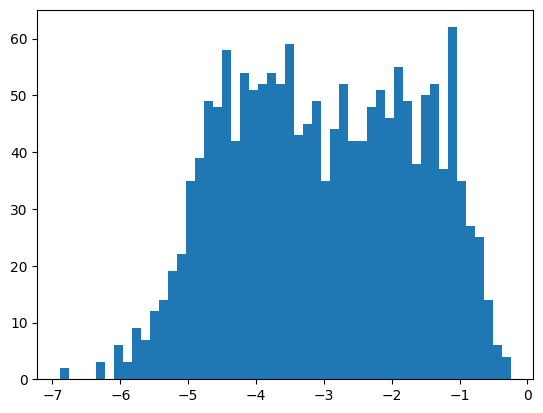

In [24]:
plt.hist(
    NCO_df.filter(pl.col("grch37_recombining_interval_cM") > 0)["grch37_recombining_interval_cM"].log10().to_numpy(),
    bins=50,
);

In [ ]:
plt.hist(
    NCO_df["upper_bound"].log10().to_numpy(),
    bins=50,
);

In [49]:
10**3.5

3162.2776601683795

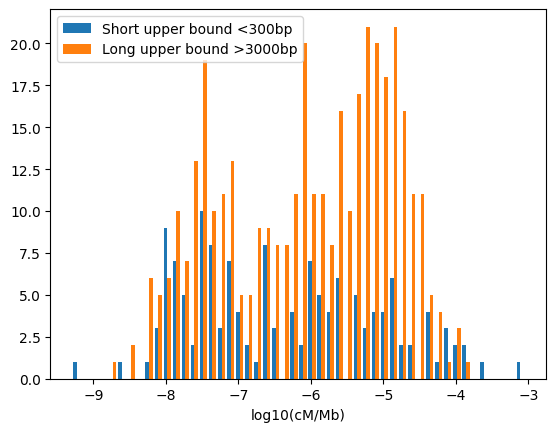

In [52]:
short_rates = \
    (NCO_df
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("upper_bound") < 300)
    )["grch37_cM_per_bp_across_recombining_interval"].log10().to_numpy()
long_rates = (NCO_df
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("upper_bound") > 3000)
    )["grch37_cM_per_bp_across_recombining_interval"].log10().to_numpy()

plt.hist(
    [short_rates, long_rates],
    bins=50,
);
plt.xlabel("log10(cM/Mb)")
plt.legend(["Short upper bound <300bp", "Long upper bound >3000bp"]);

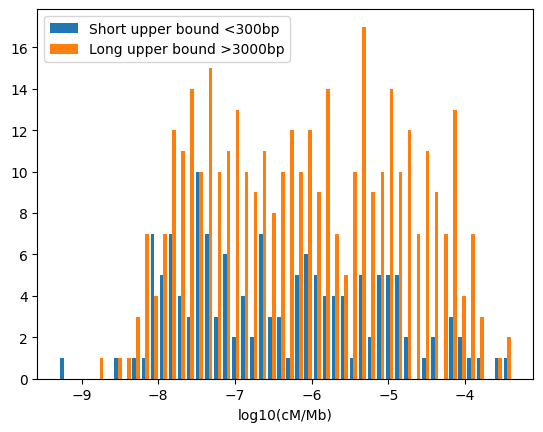

In [64]:
short_rates = \
    (NCO_df
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("upper_bound") < 300)
    )["grch37_first_converted_marker_poses_rate"].log10().to_numpy()
long_rates = (NCO_df
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("upper_bound") > 3000)
    )["grch37_first_converted_marker_poses_rate"].log10().to_numpy()

plt.hist(
    [short_rates, long_rates],
    bins=50,
);
plt.xlabel("log10(cM/Mb)")
plt.legend(["Short upper bound <300bp", "Long upper bound >3000bp"]);

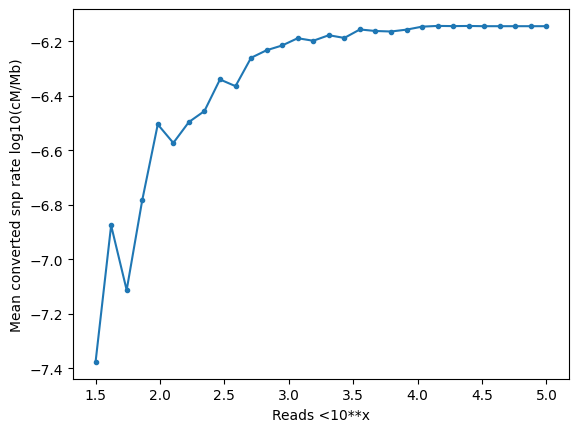

In [65]:
xs = np.linspace(1.5, 5, 30);
ys = []
for x in xs:
    y = (NCO_df
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("upper_bound") < 10**x)
    )["grch37_cM_per_bp_across_recombining_interval"].log10().to_numpy().mean()
    ys.append(y)
    
plt.plot(xs, ys, '.-');
plt.xlabel("Reads <10**x")
plt.ylabel("Mean converted snp rate log10(cM/Mb)");

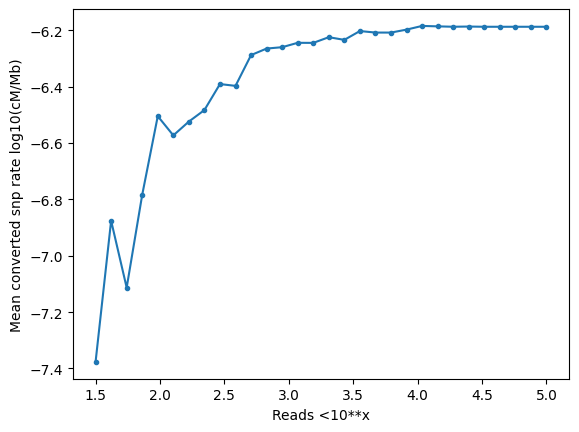

In [66]:
xs = np.linspace(1.5, 5, 30);
ys = []
for x in xs:
    y = (NCO_df
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("upper_bound") < 10**x)
    )["grch37_first_converted_marker_poses_rate"].log10().to_numpy().mean()
    ys.append(y)
    
plt.plot(xs, ys, '.-');
plt.xlabel("Reads <10**x")
plt.ylabel("Mean converted snp rate log10(cM/Mb)");

# cM vs dataset

Text(0, 0.5, 'Density')

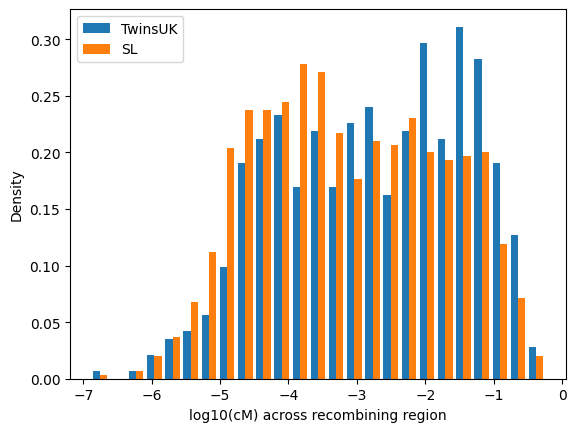

In [76]:
rahabri_cm = NCO_df.filter((pl.col("sample_id").is_in(rahbari_sample_ids)) & (pl.col("grch37_recombining_interval_cM") > 0))["grch37_recombining_interval_cM"].log10().to_numpy()
sudmant_cm = NCO_df.filter((pl.col("sample_id").is_in(sudmant_sample_ids)) & (pl.col("grch37_recombining_interval_cM") > 0))["grch37_recombining_interval_cM"].log10().to_numpy()

plt.hist(
    [
        rahabri_cm, sudmant_cm,
    ],
    bins=25,
    density=True,
);

plt.legend(["TwinsUK", "SL"]);
plt.xlabel("log10(cM) across recombining region")
plt.ylabel("Density")

In [77]:
scipy.stats.ks_2samp(rahabri_cm, sudmant_cm)

KstestResult(statistic=0.12645341939158083, pvalue=1.7797241161557757e-05, statistic_location=-3.140671020213203, statistic_sign=-1)

# Posterior probability of being from a component

In [84]:
%%time
probs_per_read = inference.component_likelihood_many_reads(
    numba.typed.List(NCO_df["read_length"].to_numpy()),
    numba.typed.List(NCO_df["snp_positions_on_read"].to_numpy()),
    numba.typed.List(NCO_df["idx_transitions"].to_numpy()),
    numba.typed.List(NCO_df["between_mid_quality_snps_cM"].to_numpy()),
    numba.typed.List(NCO_df["before_read_cM"].to_numpy()),
    numba.typed.List(NCO_df["after_read_cM"].to_numpy()),
    q = 0.142,
    #m = 0.982,
    m = 0.5,
    GC_tract_mean = 34.6,
    GC_tract_mean2 = 7216,
    read_margin_in_bp = 5000,
)

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 53.4 ms


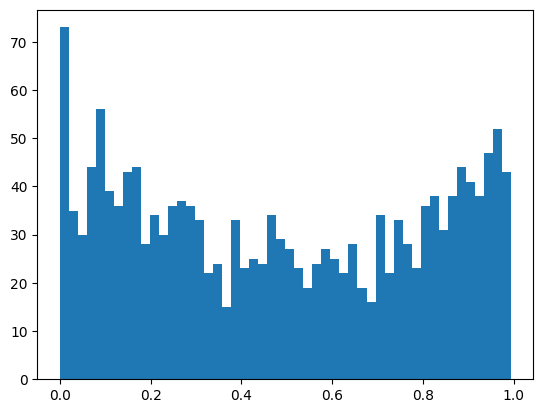

In [85]:
plt.hist(probs_per_read, bins=50);

In [86]:
np.nanmean(probs_per_read)

0.48402072279223024

In [87]:
fine = ~np.isnan(probs_per_read)

In [88]:
scipy.stats.pearsonr(
    probs_per_read[fine],
    NCO_df["upper_bound"].to_numpy()[fine],
)

PearsonRResult(statistic=-0.6848156981292407, pvalue=1.5562375956435348e-227)

<Axes: >

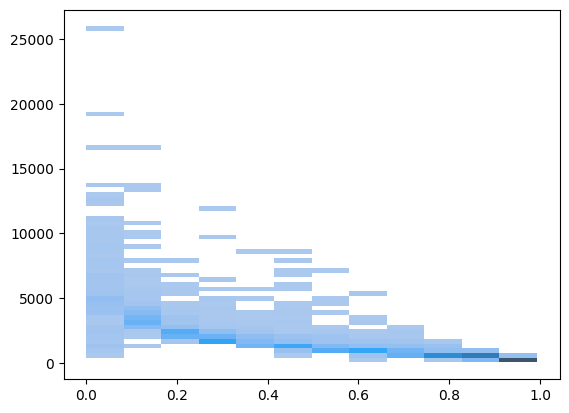

In [89]:
sns.histplot(
    x=probs_per_read[fine],
    y=NCO_df["upper_bound"].to_numpy()[fine],
)

In [90]:
scipy.stats.pearsonr(
    probs_per_read[fine],
    NCO_df["grch37_first_converted_marker_poses_rate"].log10().to_numpy()[fine],
)

PearsonRResult(statistic=-0.031028863274187475, pvalue=0.2090068866094075)

/tmp/ipykernel_277541/664762624.py:8: RuntimeWarning: Mean of empty slice.
  )["grch37_first_converted_marker_poses_rate"].log10().to_numpy().mean()
/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


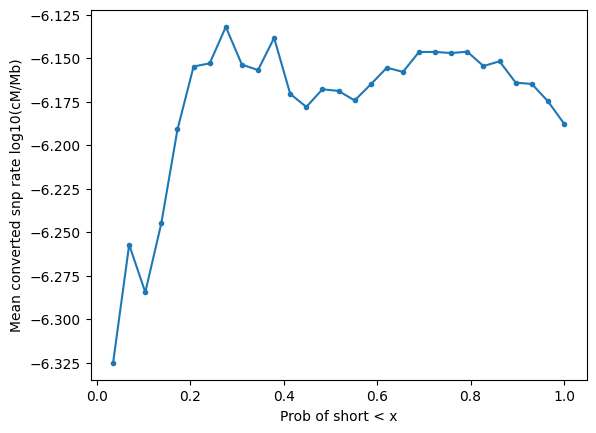

In [91]:
xs = np.linspace(0, 1, 30);
ys = []
for x in xs:
    y = (NCO_df
        .with_columns(prob=probs_per_read)
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("prob") < x)
    )["grch37_first_converted_marker_poses_rate"].log10().to_numpy().mean()
    ys.append(y)
    
plt.plot(xs, ys, '.-');
plt.xlabel("Prob of short < x")
plt.ylabel("Mean converted snp rate log10(cM/Mb)");

ttest TtestResult(statistic=-0.7292678296917527, pvalue=0.4659420453487406, df=1639.0)
KS KstestResult(statistic=0.04027713625866051, pvalue=0.5034459534081875, statistic_location=-5.582892170430529, statistic_sign=1)


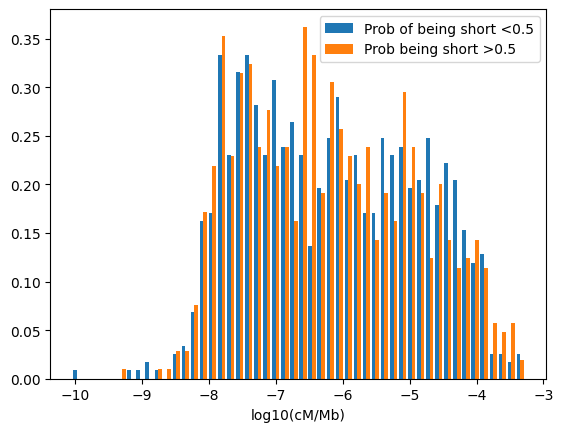

In [96]:
short_rates = \
    (NCO_df
        .with_columns(prob=probs_per_read)
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("prob") < 0.5)
    )["grch37_first_converted_marker_poses_rate"].log10().to_numpy()
long_rates = (NCO_df
        .with_columns(prob=probs_per_read)
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("prob") > 0.5)
    )["grch37_first_converted_marker_poses_rate"].log10().to_numpy()

plt.hist(
    [short_rates, long_rates],
    bins=50,
    density=True,
);
plt.xlabel("log10(cM/Mb)")
plt.legend(["Prob of being short <0.5", "Prob being short >0.5"]);

print("ttest", scipy.stats.ttest_ind(long_rates, short_rates))
print("KS", scipy.stats.ks_2samp(long_rates, short_rates))

ttest TtestResult(statistic=-0.9856840371195427, pvalue=0.32533762153399515, df=227.0)
KS KstestResult(statistic=0.09878815769289769, pvalue=0.5883275536753518, statistic_location=-5.589877653370351, statistic_sign=1)


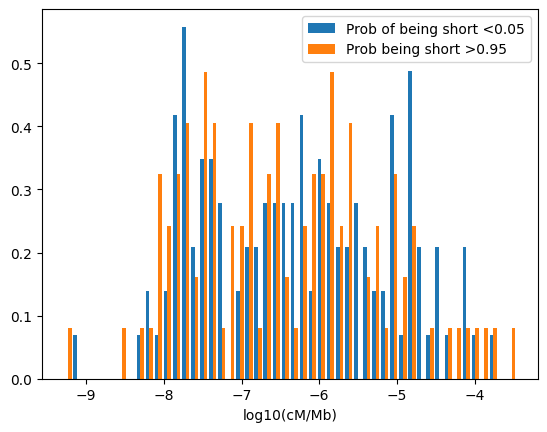

In [99]:
short_rates = \
    (NCO_df
        .with_columns(prob=probs_per_read)
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("prob") < 0.05)
    )["grch37_first_converted_marker_poses_rate"].log10().to_numpy()
long_rates = (NCO_df
        .with_columns(prob=probs_per_read)
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("prob") > 0.95)
    )["grch37_first_converted_marker_poses_rate"].log10().to_numpy()

plt.hist(
    [short_rates, long_rates],
    bins=50,
    density=True,
);
plt.xlabel("log10(cM/Mb)")
plt.legend(["Prob of being short <0.05", "Prob being short >0.95"]);

print("ttest", scipy.stats.ttest_ind(long_rates, short_rates))
print("KS", scipy.stats.ks_2samp(long_rates, short_rates))

ttest TtestResult(statistic=-0.9213170549767622, pvalue=0.35702050811934793, df=1639.0)
KS KstestResult(statistic=0.06494226327944573, pvalue=0.05989461081386902, statistic_location=-5.671007157935318, statistic_sign=1)


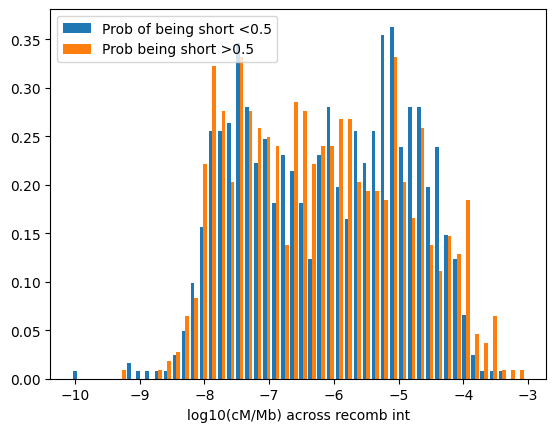

In [101]:
short_rates = \
    (NCO_df
        .with_columns(prob=probs_per_read)
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("prob") < 0.5)
    )["grch37_cM_per_bp_across_recombining_interval"].log10().to_numpy()
long_rates = (NCO_df
        .with_columns(prob=probs_per_read)
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("prob") > 0.5)
    )["grch37_cM_per_bp_across_recombining_interval"].log10().to_numpy()

plt.hist(
    [short_rates, long_rates],
    bins=50,
    density=True,
);
plt.xlabel("log10(cM/Mb) across recomb int")
plt.legend(["Prob of being short <0.5", "Prob being short >0.5"]);

print("ttest", scipy.stats.ttest_ind(long_rates, short_rates))
print("KS", scipy.stats.ks_2samp(long_rates, short_rates))

ttest TtestResult(statistic=-0.8292139533704257, pvalue=0.4074229771687995, df=450.0)
KS KstestResult(statistic=0.11883738766199288, pvalue=0.07489618093710483, statistic_location=-6.397193882882708, statistic_sign=1)


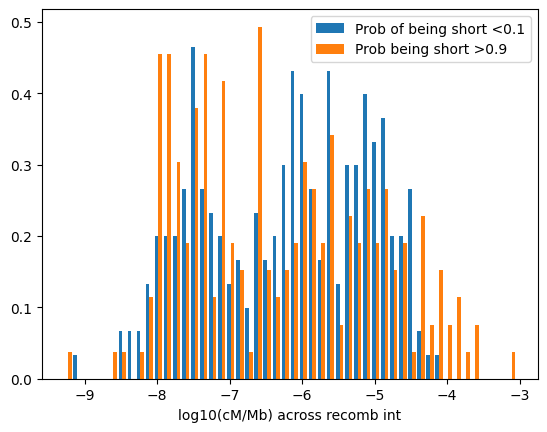

In [102]:
short_rates = \
    (NCO_df
        .with_columns(prob=probs_per_read)
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("prob") < 0.1)
    )["grch37_cM_per_bp_across_recombining_interval"].log10().to_numpy()
long_rates = (NCO_df
        .with_columns(prob=probs_per_read)
        .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
        .filter(pl.col("prob") > 0.9)
    )["grch37_cM_per_bp_across_recombining_interval"].log10().to_numpy()

plt.hist(
    [short_rates, long_rates],
    bins=50,
    density=True,
);
plt.xlabel("log10(cM/Mb) across recomb int")
plt.legend(["Prob of being short <0.1", "Prob being short >0.9"]);

print("ttest", scipy.stats.ttest_ind(long_rates, short_rates))
print("KS", scipy.stats.ks_2samp(long_rates, short_rates))

# GC-bias

## Prepare

### Make a dataframe of positions of all converted SNPs

In [56]:
converted_snps_df = (NCO_df
    .with_columns(
        (pl.col("idx_transitions").list.get(0)+1).alias("A"),
        (pl.col("idx_transitions").list.get(1) - pl.col("idx_transitions").list.get(0)).alias("B"),
    )
    .select(
        "sample_id",
        "chrom",
        "read_name",
        pl.col("snp_positions_on_read").list.slice(pl.col("A"), pl.col("B")).alias("start"),
        pl.col("AA_heat").is_not_null().alias("has_AA_DSB"),
    )
    .explode("start")
)

### Cross it with the sequences

In [57]:
dfs = []
for focal_sample_id in tqdm.tqdm(sample_ids):
    for chrom in aut_chrom_names:
        high_conf_snps_df = pl.scan_parquet(
            str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.high_confidence_snps.parquet")
        )
        
        df = (converted_snps_df
            .lazy()
            .filter(
                (pl.col("sample_id") == focal_sample_id) & \
                (pl.col("chrom") == chrom)
            )
            .join(
                (high_conf_snps_df
                    .select(
                        "read_name",
                        "start",
                        "refseq_start1",
                        "refseq_start2",    
                        "fits1_more",
                    )
                ),
                on=["read_name", "start"],
                how="left",
            )
        ).collect()
        dfs.append(df)
        
converted_snps_with_seq_df = pl.concat(dfs)

converted_snps_with_seq_df = converted_snps_with_seq_df.filter(
    (pl.col("refseq_start1").is_in(["G", "C"]) & pl.col("refseq_start2").is_in(["A", "T"])) |
    (pl.col("refseq_start2").is_in(["G", "C"]) & pl.col("refseq_start1").is_in(["A", "T"]))
)

100%|██████████| 15/15 [11:33<00:00, 46.23s/it]


In [58]:
print("# of converted SNPs:", len(converted_snps_with_seq_df))
print("# of NCO reads:", converted_snps_with_seq_df.n_unique(["read_name"]))

# of converted SNPs: 1515
# of NCO reads: 1384


## What is the total GC bias?

In [76]:
import statsmodels.stats.proportion

def calculate_gc_stats(df, limited_sample_ids, just_return=True):
    gc_stats_df = (df
        .filter(pl.col("sample_id").is_in(limited_sample_ids))
        .select(
            pl.when(pl.col("fits1_more") == 1).then(pl.col("refseq_start1")).otherwise(pl.col("refseq_start2")).alias("base")
        )
        .group_by("base")
        .len()
    )
                   
    stats_D = dict(gc_stats_df.rows())

    n_GC = stats_D.get("G", 0) + stats_D.get("C", 0)
    n_AT = stats_D.get("A", 0) + stats_D.get("T", 0)
                   
    if just_return:
        return n_GC / np.float64(n_GC+n_AT)
    else:
        print("n_GC, n_AT:", n_GC, n_AT)
        print("GC-bias:", n_GC / (n_GC+n_AT))
        print("CI:", statsmodels.stats.proportion.proportion_confint(n_GC, (n_GC+n_AT), method="binom_test"))

In [60]:
calculate_gc_stats(converted_snps_with_seq_df, sample_ids)

0.5828382838283829

In [61]:
len(converted_snps_with_seq_df)

1515

In [62]:
len(NCO_df)

1641

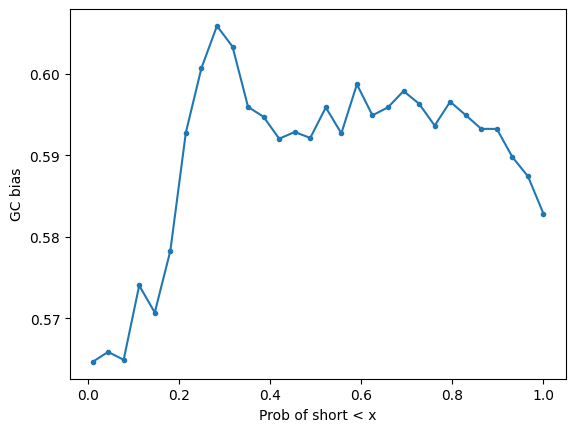

In [103]:
xs = np.linspace(0.01, 1, 30);
ys = []
for x in xs:
    y = calculate_gc_stats(
        (NCO_df
            .with_columns(prob=probs_per_read)
            .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
            .filter(pl.col("prob") < x)
            .join(converted_snps_with_seq_df, on="read_name")
        ),
        sample_ids
    ),
    ys.append(y)
    
plt.plot(xs, ys, '.-');
plt.xlabel("Prob of short < x")
plt.ylabel("GC bias");

/tmp/ipykernel_277541/1565169836.py:19: RuntimeWarning: invalid value encountered in scalar divide
  return n_GC / np.float64(n_GC+n_AT)


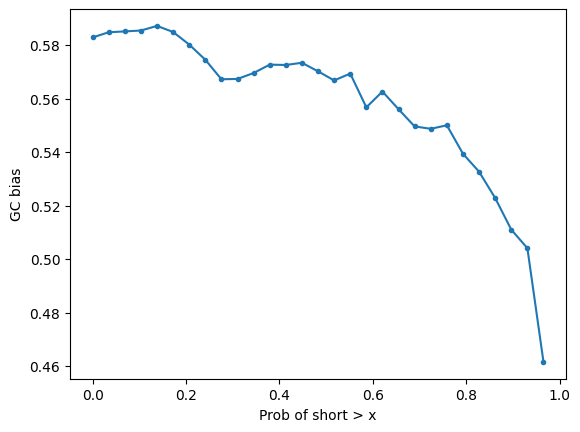

In [104]:
xs = np.linspace(0, 1, 30);
ys = []
for x in xs:
    y = calculate_gc_stats(
        (NCO_df
            .with_columns(prob=probs_per_read)
            .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
            .filter(pl.col("prob") > x)
            .join(converted_snps_with_seq_df, on="read_name")
        ),
        sample_ids
    ),
    ys.append(y)
    
plt.plot(xs, ys, '.-');
plt.xlabel("Prob of short > x")
plt.ylabel("GC bias");

In [80]:
scipy.stats.pearsonr(
    probs_per_read[fine],
    NCO_df["grch37_first_converted_marker_poses_rate"].log10().to_numpy()[fine],
)

PearsonRResult(statistic=0.02897871032588203, pvalue=0.24069238608010624)

In [81]:
scipy.stats.pearsonr(
    NCO_df["upper_bound"].log10().to_numpy()[fine],
    NCO_df["grch37_first_converted_marker_poses_rate"].log10().to_numpy()[fine],
)

PearsonRResult(statistic=0.06821950173328076, pvalue=0.005698621728173069)

In [82]:
scipy.stats.pearsonr(
    NCO_df["upper_bound"].log10().to_numpy()[fine],
    probs_per_read[fine],
)

PearsonRResult(statistic=-0.42191093784179134, pvalue=7.97585290183433e-72)

# Correlate cM to QC

In [105]:
NCO_df.columns

['read_name',
 'read_length',
 'chrom',
 'sample_id',
 'grch37_chromosome_size_in_bp',
 'high_quality_snp_positions',
 'high_quality_snp_positions_alleles',
 'CO_active_interval_start',
 'CO_active_interval_end',
 'CO_active_interval_length_bp',
 'CO_active_interval_start_cM',
 'CO_active_interval_end_cM',
 'NCO_active_interval_start',
 'NCO_active_interval_end',
 'NCO_active_interval_length_bp',
 'grch37_reference_start',
 'grch38_reference_start',
 'grch37_reference_end',
 'grch38_reference_end',
 'grch37_reference_start_cM',
 'grch37_reference_end_cM',
 'NCO_active_interval_start_cM',
 'NCO_active_interval_end_cM',
 'CO_active_interval_crossover_prob',
 'full_read_crossover_prob',
 'mid_CO_active_interval_crossover_prob',
 'NCO_active_interval_crossover_prob',
 'NCO_prob_detection_in_CO_active_interval',
 'AA_motif_center_pos',
 'AA_heat',
 'AA_motif_strand',
 'is_high_quality_read',
 'min_coverage_hap1',
 'min_coverage_hap2',
 'high_quality_classification_class',
 'snp_positions_on

In [124]:
min_cov = np.minimum(
    NCO_df["min_coverage_hap1"], NCO_df["min_coverage_hap2"], 
).to_numpy()

rates = NCO_df["grch37_first_converted_marker_poses_rate"].log10().to_numpy()

is_dsb = NCO_df["AA_heat"].is_not_null().to_numpy().astype(int)

In [125]:
scipy.stats.spearmanr(rates, min_cov)

SignificanceResult(statistic=-0.18531699315945802, pvalue=3.8203943024852773e-14)

In [126]:
scipy.stats.spearmanr(min_cov, is_dsb)

SignificanceResult(statistic=-0.1662176158682589, pvalue=1.2405829386039886e-11)

(array([[ 0., 18., 28., 28., 47., 43., 58., 38., 59., 58., 47., 38., 39.,
         47., 26., 42., 32., 28., 17., 16., 17.,  9.,  6.,  3.,  5.,  5.,
          0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 12., 15., 28., 34., 52., 51., 40., 40., 35., 51., 48., 41.,
         57., 53., 61., 39., 47., 51., 27., 26., 30., 10.,  9., 10.,  6.,
          3.,  4.,  1.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39.]),
 <a list of 2 BarContainer objects>)

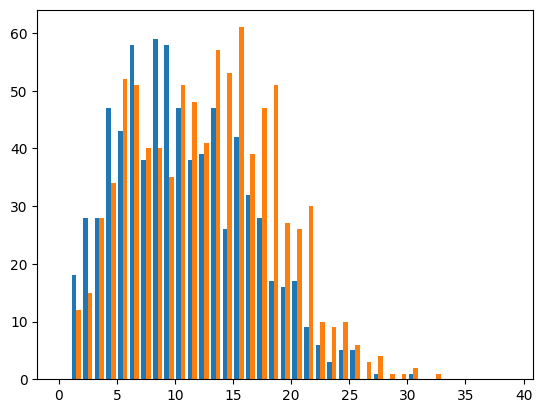

In [130]:
plt.hist(
    [
        min_cov[is_dsb.astype(bool)],
        min_cov[~is_dsb.astype(bool)],
    ],
    bins=np.arange(0, 40),
)

<Axes: xlabel='grch37_first_converted_marker_poses_rate', ylabel='min_coverage_hap1'>

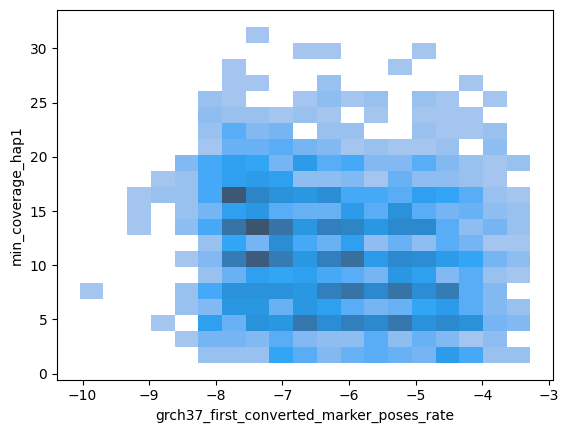

In [114]:
sns.histplot(x=rates, y=min_cov)